In [1]:
import pickle
with open('dictionary.pickle','rb') as f:
    dictionary = pickle.load(f)

import numpy as np

from matplotlib import pyplot as plt

import mdtraj as md 
from matplotlib.colors import LogNorm
import nglview as nv
import ipywidgets as widgets

def compute_phi_psi(traj):
    """Compute backbone dihedrals.

    Parameters
    ----------
    traj : mdtraj.Trajectory
    """
    phi_atoms = [25,27,29,46]
    phi = md.compute_dihedrals(traj, indices=[phi_atoms])[:, 0]
    psi_atoms = [27,29,46,48]
    psi = md.compute_dihedrals(traj, indices=[psi_atoms])[:, 0]
    return phi, psi

def get_extension(samples):
    xyzs = samples.reshape(samples.shape[0],-1,3)
    atom1, atom10 = xyzs[:,0,:], xyzs[:,150,:]
    distance = np.linalg.norm(atom1 - atom10, axis = 1).mean()
    return distance

def plot_phi_psi(ax, trajectory, topology):
    if not isinstance(trajectory, md.Trajectory):
        trajectory = md.Trajectory(
            xyz=trajectory.reshape(-1, 175, 3), 
            topology=topology
        )
    phi, psi = compute_phi_psi(trajectory)
    
    ax.hist2d(phi, psi, 50, norm=LogNorm())
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel("$\phi$")
    _ = ax.set_ylabel("$\psi$")
    
    return trajectory

def get_extension(samples):
    xyzs = samples.reshape(samples.shape[0],-1,3)
    atom1, atom10 = xyzs[:,0,:], xyzs[:,150,:]
    distance = np.linalg.norm(atom1 - atom10, axis = 1).mean()
    return distance


def plot_energies(ax, energies_sorted, test_data_energies, zoom = False):
    energies_sorted = energies_sorted.numpy()
    test_data_energies = test_data_energies.numpy()
    #sample_energies = target_energy.energy(torch.Tensor(samples)).numpy()
    #md_energies = target_energy.energy(torch.Tensor(test_data[:len(samples)])).cpu().detach().numpy()
    cut = max(np.percentile(energies_sorted, 80), 20)
    if zoom == True:
        
        cut = cut * 1e-7
    #print(f"cut {cut}")
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    ax2.hist(energies_sorted, range=(-50, cut), bins=40, density=False, label="BG")
    ax2.hist(test_data_energies, range=(-50, cut), bins=40, density=False, label="MD", alpha = 0.5)
    ax2.set_ylabel(f"Count   [#Samples / {len(energies_sorted)}]")
    ax2.legend()


def evaluate_generator(samples_sorted, energies_sorted, test_data_energies, topology, num_energy = 1000, num_widget = 100):

    extension = get_extension(samples_sorted)
    print(f'mean extension: {extension:.2f}')
    
    
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    
    plot_energies(axes[0], energies_sorted, test_data_energies, zoom = True)
    plot_energies(axes[1], energies_sorted, test_data_energies)

    #plot_tics(samples, axes[0])
    plot_phi_psi(axes[2], samples_sorted, topology)
    fig.tight_layout()
    global widget
    
    widget = show_structures(np.concatenate((samples_sorted[:100],samples_sorted[-100:])))
    
    init_value = np.around(energies_sorted[0].item(), decimals = 2)
    output2 = widgets.BoundedFloatText(
        value = init_value,
        description='Energy [ $k_B T$ ]] :',
        disabled=True,
        min = -1e20,
        max = 1e50
    )
    display(output2)
    
    def on_value_change(change):
        if change['new'] > 99:
            value = np.around(energies_sorted[change['new']+800].item(), decimals = 2)
        else:
            value = np.around(energies_sorted[change['new']].item(), decimals = 2)
        output2.value = value
    widget._iplayer._trait_values["children"][1].observe(on_value_change, names='value')

    display(widget)    

def show_structures(traj, top=dictionary["mdtraj_topology"]):
    if not isinstance(traj, md.Trajectory):
        n_samples = traj.shape[0]
        traj = md.Trajectory(traj.reshape(n_samples, -1, 3), topology=top)
    traj.superpose(traj)
    widget = nv.show_mdtraj(traj)
    widget.add_representation("licorice")
    return widget
    

below, samples of the chignoline BG can be inspected. the fist 100 samples are the 100 lowest energy samples from 1000 samples. samples 100 to 199 are the highest energy samples of 1000.

mean extension: 1.37


BoundedFloatText(value=20.99, description='Energy [ $k_B T$ ]] :', disabled=True, max=1e+50, min=-1e+20)

NGLWidget(max_frame=199)

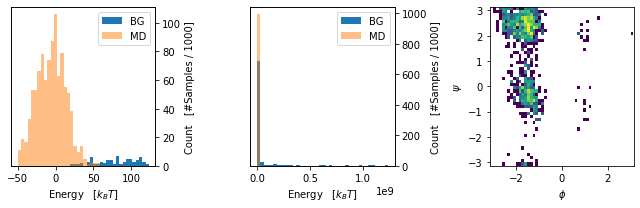

In [2]:
evaluate_generator(samples_sorted = dictionary["samples_sorted"], energies_sorted = dictionary["energies_sorted"][:1000], test_data_energies = dictionary["test_data_energies"].squeeze()[:1000],
                  topology = dictionary["mdtraj_topology"])

In [63]:
widget.clear()

In [50]:
selection = dictionary["mdtraj_topology"].select("resid == 8")

In [51]:
selection = dictionary["mdtraj_topology"].select("protein")

In [53]:
widget.add_representation("licorice", selection=selection)

In [49]:
dictionary.keys()

dict_keys(['samples_sorted', 'energies_sorted', 'mdtraj_topology', 'test_data_energies', 'test_data_samples'])